## This notebook applies negative error probabilities using the Monte-Carlo sampling, where initial error probabilities are learned using Qiskit noise characterization. 

In [1]:
import pennylane as qml
import qutip as qt
from qutip import *  

import numpy as np
import matplotlib.pyplot as plt

from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline 

## Problem Hamiltonian

In [2]:
N = 3

# pre-allocate operators
si = qt.qeye(2)
sx = qt.sigmax()
sy = qt.sigmay()
sz = qt.sigmaz()

sx_list = []     
sy_list = []
sz_list = []

for n in range(N):
    op_list = []
    for m in range(N):
        op_list.append(si)

    op_list[n] = sz
    sz_list.append(qt.tensor(op_list))
    
for n in range(N):
    op_list = []
    for m in range(N):
        op_list.append(si)

    op_list[n] = sy
    sy_list.append(qt.tensor(op_list))
    

for n in range(N):
    op_list = []
    
    for m in range(N):
        op_list.append(si)
        
    op_list[n] = sx
    sx_list.append(qt.tensor(op_list))

In [3]:
def problem_hamiltonian(N, seed):
    np.random.seed(seed)

    edge_2q = ([])
    edge_nn = ([])
    J = np.zeros((N,N))
    jp = []
    for i in range(N):
        for j in range(N):
            if j>i:
                edge_2q.append((i,j))
                J[i][j] =np.round(np.random.uniform(-1,1),2)

                jp.append(J[i][j])
                
    for i in range(N):
        for j in range(N):
            if j==i+1:
                edge_nn.append((i,j))

    h = []
    for i in range(N):
        h.append(np.round(20*np.random.uniform(-1,1),2))
        #h.append(-1)

    H_x = 0
    for i in range(len(h)):
        H_x+=h[i]*sz_list[i]  # Local terms 

    H_ij = 0
    k = 0 
    for edge in edge_2q:
        i = edge[0]
        j = edge[1]
        # interaction terms
        H_ij += jp[k] * sz_list[i] * sz_list[j]  # Interaction terms
        k+=1

    hc = (H_ij+ H_x)
    K = np.real(np.diag(hc.full()).tolist()).tolist()

    return hc, edge_2q, edge_nn, h, jp, J, K


In [4]:
def fidelity_qutip(rho1, rho2):
    """
    Compute fidelity between two density matrices using Qutip.
    
    rho1, rho2: Qutip Qobj density matrices
    """
    return qt.fidelity(rho1, rho2)

In [5]:
seed = 24
prob_h = problem_hamiltonian(N,seed = seed)[0]
K = problem_hamiltonian(N,seed = seed)[6] 
np.min(K)
# prob_h

-26.83

In [6]:
gs_energy = prob_h.eigenstates()[0][0]
gs = prob_h.eigenstates()[1][0]
rh_qutip_op = gs*gs.dag()

print(gs_energy)

-26.83


## Driver Hamiltonian

In [7]:
h, jp = problem_hamiltonian(N, seed = seed)[3], problem_hamiltonian(N, seed = seed)[4] 

H_x = 0 
for i in range(len(h)):
    H_x+=sx_list[i]  # Local terms 

hd = (-H_x) 

In [8]:
o_hd = []
for i in range(N):
    o_hd.append(qml.PauliX(i))
    
c_hd = [-1]*N

driver_h = qml.Hamiltonian(c_hd, o_hd)
driver_h

-1 * X(0) + -1 * X(1) + -1 * X(2)

## Commutator 

In [9]:
import itertools

def first_commutator(N, seed, graph1):
    h, jp = problem_hamiltonian(N, seed = seed)[3], problem_hamiltonian(N, seed = seed)[4]

    h_list = [- 2 * item for item in h]
    Jij_list = [- 2 * item for item in jp]

    # o_cd = []

    h_y = 0
    for i in range(N):
        h_y += h_list[i]*sy_list[i]
        # o_cd.append(qml.PauliY(i))

    H_ij = 0
    k = 0 
    for edge in graph1:
        i = edge[0]
        j = edge[1]
        H_ij += Jij_list[k] * sy_list[i] * sz_list[j]  # Interaction terms
        H_ij += Jij_list[k] * sz_list[i] * sy_list[j]  # Interaction terms
        k += 1

    commu_first = H_ij + h_y
    
    return commu_first

In [11]:
h, jp = problem_hamiltonian(N, seed = seed)[3], problem_hamiltonian(N, seed = seed)[4]
graph1 = problem_hamiltonian(N, seed = seed)[1] 

op = first_commutator(N, seed, graph1)

## Error probabilities 

In [12]:
# Input data
data = [('IYI', 0.000495018435101417), ('ZYI', 0.0009148370101589832), ('XII', 0.00010777432702382785), ('IXZ', 3.1545884368385507e-05), ('IXI', 0.0006046326001171507), ('XII', 7.526607900406381e-05), ('IXX', 0.00036838238141547255), ('YXI', 1.6817199893082228e-05), ('YII', 6.985366946050551e-05), ('IZI', 0.0033398655383545996), ('ZII', 0.00011313873615702958), ('IIX', 3.937691265307485e-06), ('IZZ', 5.825477241087637e-05), ('IZY', 0.00011872906295227361), ('IZI', 0.00041229446224651776), ('IXX', 1.635814222551901e-05), ('ZXI', 7.466961284011499e-05), ('IZI', 0.00030888065469906155), ('YZI', 6.780921625122265e-05), ('IYY', 5.195981140560146e-05), ('XYI', 1.6072548931333763e-05), ('YZI', 2.3852560101057888e-05), ('IIZ', 0.00048762385635260793), ('IIY', 0.0012874721005326538), ('IZZ', 0.0001364588361555782), ('IZX', 0.0004380108606459997)]

# Mapping from characters to qutip operators
pauli_map = {
    "X": sx,
    "Y": sy,
    "Z": sz,
    "I": si
}

mf = 100

# Construct c_ops
c_ops = 0
for pauli_string, coeff in data:
    if coeff != 0:  # Skip zero coefficients
        operators = [pauli_map[char] for char in pauli_string]  # Map string to operators
        tensor_op = qt.tensor(operators)  # Create the tensor product
        c_ops = c_ops + np.sqrt(coeff*mf) * tensor_op
        # c_ops.append(np.sqrt(coeff) * tensor_op)
c_ops

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=CSR, isherm=True
Qobj data =
[[ 1.47704523+0.j          0.22913071-0.46777648j  0.38847009-0.52495282j
   0.16029495+0.j          0.19057044-0.21476394j  0.        +0.j
   0.        -0.08109936j  0.        +0.j        ]
 [ 0.22913071+0.46777648j  0.64912028+0.j          0.30446125+0.j
   0.27613864-0.52495282j  0.        +0.j          0.19057044-0.21476394j
   0.        +0.j          0.        -0.08109936j]
 [ 0.38847009+0.52495282j  0.30446125+0.j         -0.82266771+0.j
  -0.18944347-0.24985075j  0.        -0.0009182j   0.        +0.j
   0.19057044+0.04760693j  0.        +0.j        ]
 [ 0.16029495+0.j          0.27613864+0.52495282j -0.18944347+0.24985075j
  -0.87803102+0.j          0.        +0.j          0.        -0.0009182j
   0.        +0.j          0.19057044+0.04760693j]
 [ 0.19057044+0.21476394j  0.        +0.j          0.        +0.0009182j
   0.        +0.j          1.26431184+0.j          0.2291

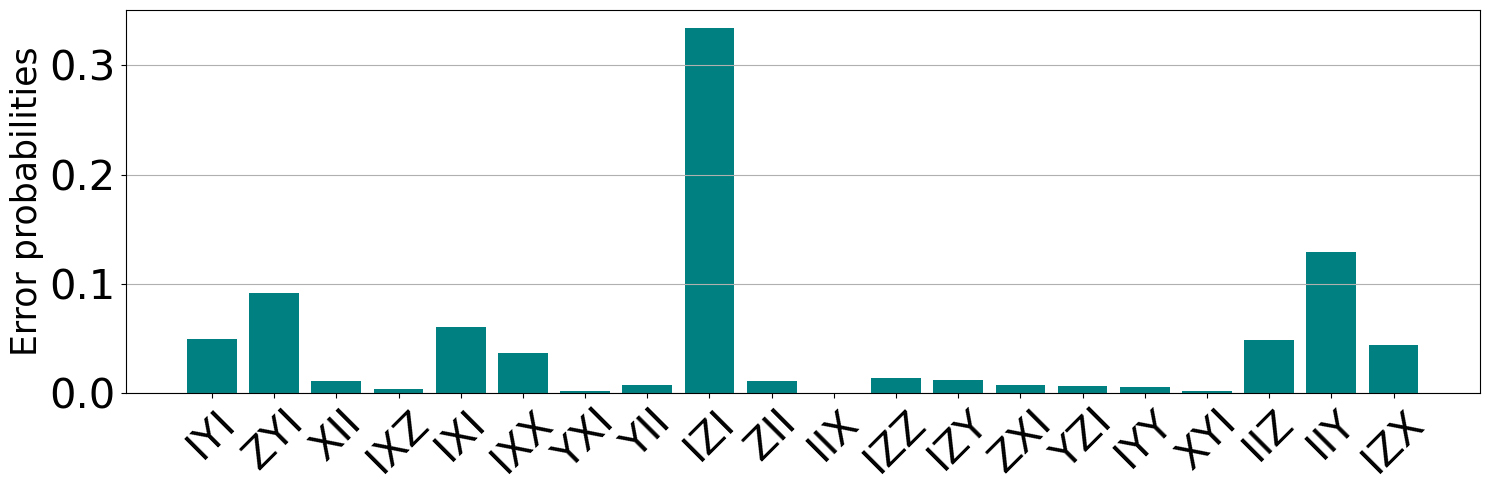

In [13]:
values=[]
for pauli, coeff in data:
    if coeff!=0:
        values.append(mf * coeff)

labels=[]
for pauli, coeff in data:
    if coeff!=0:
        labels.append(str(pauli))

fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(labels, values, color="teal")
ax.set_ylabel("Error probabilities", fontsize=25)
ax.tick_params(axis='x', labelsize=30, labelrotation=45)
ax.tick_params(axis='y', labelsize=30)
ax.grid(axis='y')
plt.tight_layout()
# plt.savefig('errprobs2.pdf')


In [14]:
# prob_h = problem_hamiltonian(N,seed = seed)[0]
graph1, J1, K = problem_hamiltonian(N, seed = seed)[1], problem_hamiltonian(N, seed = seed)[5], problem_hamiltonian(N, seed = seed)[6]
op = first_commutator(N, seed, graph1)
np.min(K)

-26.83

In [15]:
psi0 = basis(2, 0)
a = destroy(2)
psi1 = a.dag()*psi0

plus = 1/np.sqrt(2) * (psi0 + psi1)
init_state = tensor(plus, plus, plus)

dt = 0.005
# dt = 0.01

times = np.arange(0.0, 10, dt)
len(times)

2000

In [16]:
def coeff_beta(beta, t):
    return beta(t)

times1 = np.insert(times, 0, 0)

In [17]:
# Method 1

Ep = []
beta1 = [0]
beta = 0
# H_tot = [hp]

rho = init_state
states = [init_state]
stepsss = 50

for i in range(stepsss):
    H_tot_2 = prob_h + beta * hd

    result = mesolve(H_tot_2, rho, times[i:i+2], [], [op, prob_h])
    result_states = mesolve(H_tot_2, rho, times[i:i+2], [], [])

    rho = result_states.states[-1]
    states.append(result_states.states[-1])

    beta = - result.expect[0][-1] 
    beta1.append(beta)

    Ep.append(result.expect[1][-1])


In [19]:
# Method 2  

Ep1_now = []
rho = init_state
states = [init_state]
final_state = [init_state*init_state.dag()]

beta1_now = [0, 0]
h1_now = [0, 1]
stepsss = 50 

for i in range(1, stepsss):
    # print("t = ",i)
    beta_s = interp1d(times1[1:i+2], beta1_now, kind='linear', fill_value="extrapolate")
    hamil_s = interp1d(times1[1:i+2], h1_now, kind='linear', fill_value="extrapolate")

    H_tot_2 = [[prob_h, coeff_beta(hamil_s, times1[1:i+2])], [hd, coeff_beta(beta_s, times1[1:i+2])]]

    result = mesolve(H_tot_2, rho, times1[1:i+2], [], [op, prob_h])
    result_states = sesolve(H_tot_2, rho, times1[1:i+2])

    beta = - result.expect[0][-1]
    beta1_now.append(beta)
    h1_now.append(1)

    Ep1_now.append(result.expect[1][-1])
    state = result_states.states[-1]
    final_state.append(state*state.dag())


In [21]:
r_now = []
for i in range(len(Ep1_now)):
    r_now.append(Ep1_now[i]/np.min(K))
# app_ratio.append(np.array(r))


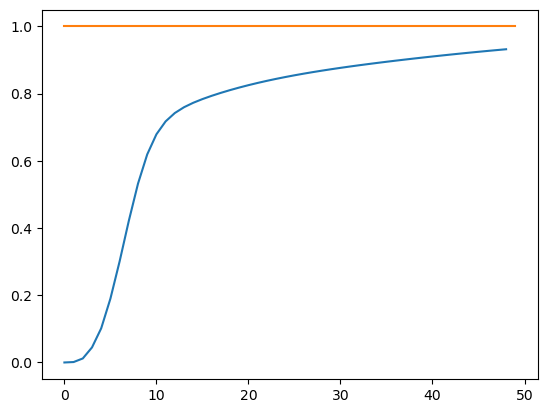

In [22]:
plt.plot(r_now) 
plt.plot([1]*stepsss)
# plt.plot(Ep)

In [23]:
succ_prob_Ep1_now = [] 
for i in range(len(final_state)):
    succ_prob_Ep1_now.append(fidelity_qutip(rh_qutip_op, final_state[i]))

In [24]:
Ep1_now_open = []
rho = init_state
states = [init_state]
final_state_open = [init_state*init_state.dag()]

beta1_now_open = [0, 0]
h1_now = [0, 1]
stepsss = 40

for i in range(1, stepsss):
    # print("t = ",i)
    beta_s = interp1d(times1[1:i+2], beta1_now_open, kind='linear', fill_value="extrapolate")
    hamil_s = interp1d(times1[1:i+2], h1_now, kind='linear', fill_value="extrapolate")

    H_tot_2 = [[prob_h, coeff_beta(hamil_s, times1[1:i+2])], [hd, coeff_beta(beta_s, times1[1:i+2])]]

    result = mesolve(H_tot_2, init_state, times1[1:i+2], c_ops, [op, prob_h])
    result_states = mesolve(H_tot_2, init_state, times1[1:i+2], c_ops, [])

    beta = - result.expect[0][-1]
    beta1_now_open.append(beta)
    h1_now.append(1)

    Ep1_now_open.append(result.expect[1][-1])
    state = result_states.states[-1]
    final_state_open.append(state*state.dag())


In [25]:
r_now_open = []
for i in range(len(Ep1_now_open)):
    r_now_open.append(Ep1_now_open[i]/np.min(K))
# app_ratio.append(np.array(r))


In [26]:
succ_prob_Ep_now_open = []

for i in range(len(final_state_open)):
    succ_prob_Ep_now_open.append(fidelity_qutip(rh_qutip_op, final_state_open[i]))

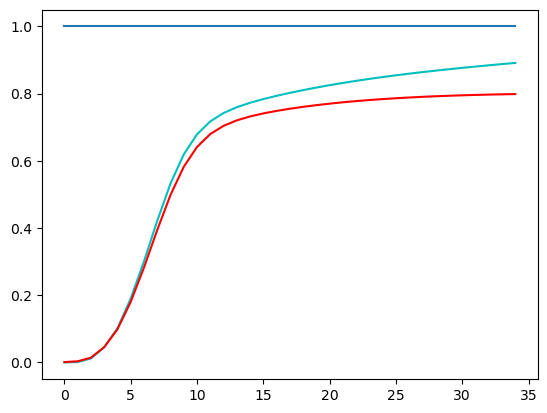

In [27]:
r = 35
plt.plot(r_now[0:r], 'c') 
plt.plot(r_now_open[0:r], 'r') 

plt.plot([1]*r)
# plt.plot(Ep)

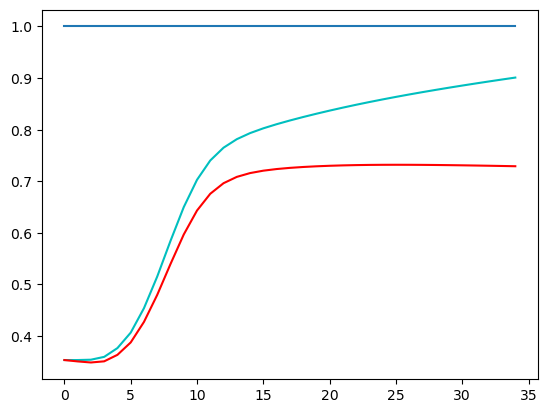

In [28]:
r = 35
plt.plot(succ_prob_Ep1_now[0:r], 'c') 
plt.plot(succ_prob_Ep_now_open[0:r], 'r') 

plt.plot([1]*r) 
# plt.plot(Ep)

In [29]:
# Construct c_ops
# c_ops = 0
OPS = []
gamma_coeffs = []
pauli_strings = []

for pauli_string, coeff in data:
    if coeff != 0:  # Skip zero coefficients
        operators = [pauli_map[char] for char in pauli_string]  # Map string to operators
        tensor_op = qt.tensor(operators)  # Create the tensor product
        second_lyapunov = tensor_op.dag() * prob_h * tensor_op - prob_h 
        OPS.append(second_lyapunov)
        gamma_coeffs.append(coeff*mf)
        pauli_strings.append(tensor_op)
        
OPS[0]

Quantum object: dims=[[2, 2, 2], [2, 2, 2]], shape=(8, 8), type='oper', dtype=CSR, isherm=True
Qobj data =
[[  7.28   0.     0.     0.     0.     0.     0.     0.  ]
 [  0.    11.28   0.     0.     0.     0.     0.     0.  ]
 [  0.     0.    -7.28   0.     0.     0.     0.     0.  ]
 [  0.     0.     0.   -11.28   0.     0.     0.     0.  ]
 [  0.     0.     0.     0.    10.96   0.     0.     0.  ]
 [  0.     0.     0.     0.     0.    14.96   0.     0.  ]
 [  0.     0.     0.     0.     0.     0.   -10.96   0.  ]
 [  0.     0.     0.     0.     0.     0.     0.   -14.96]]

In [30]:
print(gamma_coeffs)

[0.049501843510141696, 0.09148370101589832, 0.010777432702382784, 0.003154588436838551, 0.060463260011715064, 0.007526607900406381, 0.036838238141547255, 0.001681719989308223, 0.006985366946050552, 0.33398655383545994, 0.011313873615702958, 0.00039376912653074853, 0.005825477241087637, 0.01187290629522736, 0.04122944622465178, 0.001635814222551901, 0.007466961284011499, 0.030888065469906155, 0.006780921625122264, 0.0051959811405601465, 0.0016072548931333763, 0.0023852560101057887, 0.048762385635260794, 0.1287472100532654, 0.013645883615557821, 0.04380108606459997]


## Multiple gammas

In [215]:
Ep_kasf1 = []
no_gammas = 5 # no. of gamma coeffs 

e_ops = [op, prob_h]
for i in range(no_gammas):
    e_ops.append(OPS[i])

gammv = [[0, gamma_coeffs[i]] for i in range(no_gammas)]  # Example gammv values

rho = init_state
states = [init_state] 
beta1_kasf1 = [0, 0]
h1_now = [0, 1]

nmmc_options = {"map": "parallel"}  # options specific to nm_mcsolve
options = {"progress_bar": "enhanced", "store_final_state": True} 

cc = []
state_f = [init_state*init_state.dag()]
blk = [] 
tr = []

for i in range(1,26):
    # print(i)
    beta_s = interp1d(times1[1:i+2], beta1_kasf1, kind='linear', fill_value="extrapolate")
    hamil_s = interp1d(times1[1:i+2], h1_now, kind='linear', fill_value="extrapolate")

    H_tot_2 = [[prob_h, coeff_beta(hamil_s, times1[1:i+2])], [hd, coeff_beta(beta_s, times1[1:i+2])]]

    gamma_int = []
    for idx in range(no_gammas):  
        gamma_int.append(CubicSpline(times1[1:i+2], np.complex128(gammv[idx])))

    c_ops = [[pauli_strings[j], gamma_int[j]] for j in range(no_gammas)]

    result = nm_mcsolve(H_tot_2, init_state, times1[1:i+2], c_ops, e_ops, ntraj = 5000, options=(options | nmmc_options))

    beta = - result.expect[0][-1] 
    beta1_kasf1.append(beta)
    h1_now.append(1)

    b = [result.expect[2+i][-1] for i in range(no_gammas)] # modified error probs.
    blk.append(b)    

    for k in range(no_gammas):
        # # print(b[k])
        # if b[k] < 0.0:
        #     g = 0 
        if b[k] > 0.15:
            g = - 0.15
        else:
            g = - b[k]
        # if np.abs(g) < 1e-09:
        #     g = 0
        # print("g = ", g)
        gammv[k].append(g)

    Ep_kasf1.append(result.expect[1][-1])

    tr.append(result.trace[-1])
    state_f.append(result.final_state)  
    

 Total run time:  60.37s*] Elapsed 60.31s / Remaining 00:00:00:00          1%           ] Elapsed 0.51s / Remaining 00:00:00:50[****     19%           ] Elapsed 10.26s / Remaining 00:00:00:43[****     19%           ] Elapsed 10.30s / Remaining 00:00:00:43[******   26%           ] Elapsed 13.76s / Remaining 00:00:00:39[******   27%           ] Elapsed 14.84s / Remaining 00:00:00:40[*******  29%           ] Elapsed 16.30s / Remaining 00:00:00:39[*********60%**         ] Elapsed 35.07s / Remaining 00:00:00:23[*********61%**         ] Elapsed 35.88s / Remaining 00:00:00:22[*********61%**         ] Elapsed 36.11s / Remaining 00:00:00:23[*********67%***        ] Elapsed 40.01s / Remaining 00:00:00:19[*********67%***        ] Elapsed 40.55s / Remaining 00:00:00:19[*********69%****       ] Elapsed 42.60s / Remaining 00:00:00:19[*********70%****       ] Elapsed 43.47s / Remaining 00:00:00:18[*********76%*****      ] Elapsed 46.71s / Remaining 00:00:00:14[*********88%********   ] Elapsed 55.17s 

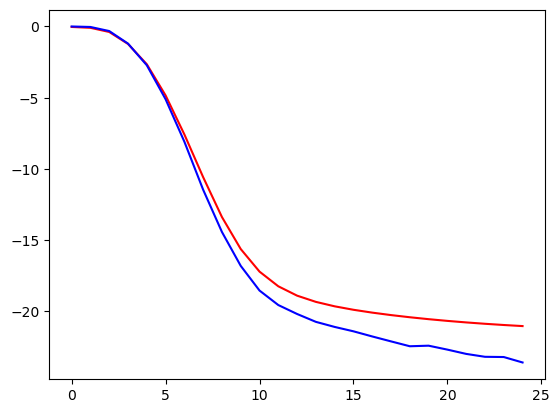

In [217]:
# plt.plot(r_now[0:k1], 'c') 
k1 = 25
plt.plot(Ep1_now_open[0:k1], 'r') 
plt.plot(Ep_kasf1[0:k1], 'b') 

In [218]:
r_kasf1 = []
for i in range(len(Ep_kasf1)):
    r_kasf1.append(Ep_kasf1[i]/np.min(K))
# app_ratio.append(np.array(r))


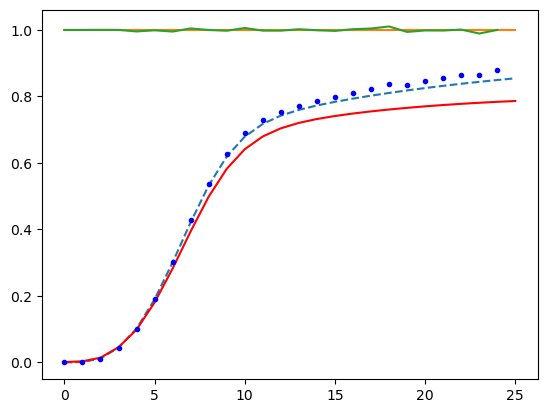

In [219]:
k1 = 26
plt.plot(r_now[0:k1], '--') 
plt.plot(r_now_open[0:k1], 'r') 
plt.plot(r_kasf1[0:k1], 'b.') 

plt.plot([1]*k1)
plt.plot(tr)
# plt.plot(Ep)

In [220]:
succ_prob_Ep_kasf1 = []

for i in range(len(state_f)):
    succ_prob_Ep_kasf1.append(fidelity_qutip(rh_qutip_op, state_f[i]))

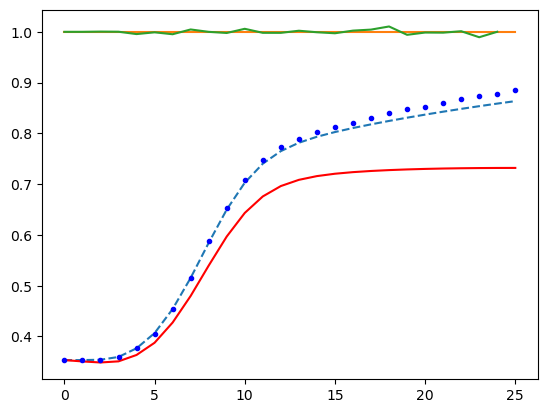

In [221]:
k1 = 26
plt.plot(succ_prob_Ep1_now[0:k1], '--') 
plt.plot(succ_prob_Ep_now_open[0:k1], 'r') 
plt.plot(succ_prob_Ep_kasf1[0:k1], 'b.') 

plt.plot([1]*k1)
plt.plot(tr)
# plt.plot(Ep)

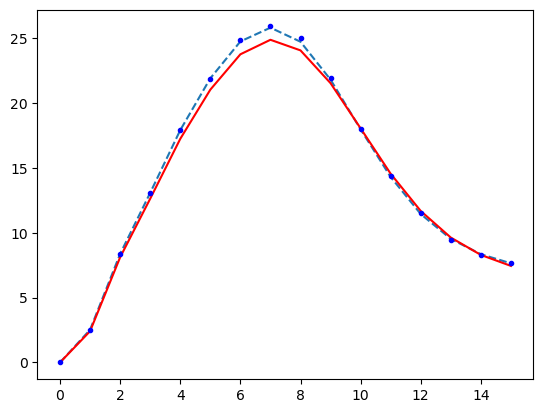

In [222]:
k1 = 17
plt.plot(beta1_now[1:k1], '--') 
plt.plot(beta1_now_open[1:k1], 'r') 
plt.plot(beta1_kasf1[1:k1], 'b.') 

In [223]:
k = 25
ntraj = 5000
kasturi = [r_now_open[0:k], r_kasf1[0:k], r_now[0:k]]
file_path = f'data_5q/r_mf_{mf}_dt_{dt}_ntraj_{ntraj}_seed_{seed}.npy'

# Write the array to a file
np.save(file_path, kasturi)

In [224]:
k = k+1 
kasturi = [succ_prob_Ep_now_open[0:k], succ_prob_Ep_kasf1[0:k], succ_prob_Ep1_now[0:k]]
file_path = f'data_5q/phi_mf_{mf}_dt_{dt}_ntraj_{ntraj}_seed_{seed}.npy'

# Write the array to a file
np.save(file_path, kasturi)

In [225]:
k = k+1
kasturi = [beta1_now_open[1:k], beta1_kasf1[1:k], beta1_now[1:k]]
file_path = f'data_5q/beta_mf_{mf}_dt_{dt}_ntraj_{ntraj}_seed_{seed}.npy'

# Write the array to a file
np.save(file_path, kasturi)

In [226]:
kasturi = gammv
file_path = f'data_5q/gamma_mf_{mf}_dt_{dt}_ntraj_{ntraj}_seed_{seed}.npy'

# Write the array to a file
np.save(file_path, kasturi)

In [7]:
N = 3
dt = 0.005
mf = 100
ntraj = 5000

In [8]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

# fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)
k = 25
# seeds = [25]

# file_path = f'data_5q/gamma_mf_{mf}_dt_{dt}_ntraj_{ntraj}_seed_{seed}.npy'
# gammv = np.load(file_path)


r_now_open_arr = []
r_kasf1_arr = []

succ_prob_now_open_arr = []
succ_prob_kasf1_arr = []

beta_now_open_arr = []
beta_kasf1_arr = []

for seed in range(24):

    file_path = f'data_5q/r_mf_{mf}_dt_{dt}_ntraj_{ntraj}_seed_{seed}.npy'
    agp_arr = np.load(file_path)
    r_now_open, r_kasf1, r1_now = agp_arr[0], agp_arr[1], agp_arr[2]
    r_now_open_arr.append(r_now_open)
    r_kasf1_arr.append(r_kasf1)

    file_path = f'data_5q/beta_mf_{mf}_dt_{dt}_ntraj_{ntraj}_seed_{seed}.npy'
    agp_arr2 = np.load(file_path)
    beta_now_open, beta_kasf1, beta1_now = agp_arr2[0], agp_arr2[1], agp_arr2[2]
    beta_now_open_arr.append(beta_now_open)
    beta_kasf1_arr.append(beta_kasf1)

    file_path = f'data_5q/phi_mf_{mf}_dt_{dt}_ntraj_{ntraj}_seed_{seed}.npy'
    agp_arr3 = np.load(file_path)
    succ_prob_now_open, succ_prob_kasf1, succ_prob1_now = agp_arr3[0], agp_arr3[1], agp_arr3[2]
    succ_prob_now_open_arr.append(succ_prob_now_open)
    succ_prob_kasf1_arr.append(succ_prob_kasf1)

In [9]:
g0 = []
g1 = []
g2 = []
g3 = []
g4 = []

for seed in range(24):
    if seed != 6:
        file_path = f'data_5q/gamma_mf_{mf}_dt_{dt}_ntraj_{ntraj}_seed_{seed}.npy'
        gammv = np.load(file_path)
        g00, g11, g22, g33, g44 = gammv[0], gammv[1], gammv[2], gammv[3], gammv[4]

        g0.append(g00[1:])
        g1.append(g11[1:])
        g2.append(g22[1:])
        g3.append(g33[1:])
        g4.append(g44[1:])


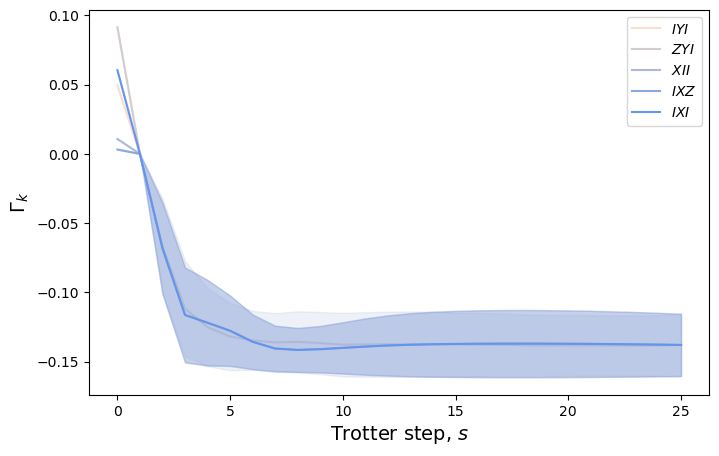

In [10]:
import matplotlib.colors as mcolors  # Needed for color conversion

array_g0 = np.column_stack(g0)
array_g1 = np.column_stack(g1)
array_g2 = np.column_stack(g2)
array_g3 = np.column_stack(g3)
array_g4 = np.column_stack(g4)

Norm_factor = 1/np.sqrt(N)

mean_values_g0 = np.mean(array_g0, axis=1)
std_values_g0 = np.std(array_g0, axis=1)

mean_values_g1 = np.mean(array_g1, axis=1)
std_values_g1 = np.std(array_g1, axis=1)

mean_values_g2 = np.mean(array_g2, axis=1)
std_values_g2 = np.std(array_g2, axis=1)

mean_values_g3 = np.mean(array_g3, axis=1)
std_values_g3 = np.std(array_g3, axis=1)

mean_values_g4 = np.mean(array_g4, axis=1)
std_values_g4 = np.std(array_g4, axis=1)


# X-axis indices
x = np.arange(len(mean_values_g0))

# colors = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231'] 
colors = ['#6495ED', '#89A7E2', '#AEB9D7', '#D3CBCC', '#F8DED1', '#F6BDC0']

green_rgb = np.array(mcolors.to_rgb('g'))   # green as [0.0, 0.5, 0.0]
magenta_rgb = np.array(mcolors.to_rgb('m'))

# Generate 5 colors interpolating between green and magenta
# colors = [green_rgb + (magenta_rgb - green_rgb) * i/4 for i in range(5)]

# colors = ['blue', 'orange', 'g', 'purple', 'olive']



# Plot mean with standard deviation
plt.figure(figsize=(8, 5))
plt.plot(x, mean_values_g0, label=r"$IYI$", color=colors[4])
plt.fill_between(x, mean_values_g0 - std_values_g0*Norm_factor, mean_values_g0 + std_values_g0 * Norm_factor, color=colors[4], alpha=0.2)

plt.plot(x, mean_values_g1, label=r"$ZYI$", color=colors[3])
plt.fill_between(x, mean_values_g1 - std_values_g1 * Norm_factor, mean_values_g1 + std_values_g1 * Norm_factor, color=colors[3], alpha=0.2)

plt.plot(x, mean_values_g2, label=r"$XII$", color=colors[2])
plt.fill_between(x, mean_values_g2 - std_values_g2 * Norm_factor, mean_values_g2 + std_values_g2 * Norm_factor,color=colors[2], alpha=0.2)

plt.plot(x, mean_values_g3, label=r"$IXZ$", color=colors[1])
plt.fill_between(x, mean_values_g3 - std_values_g3 * Norm_factor, mean_values_g3 + std_values_g3 * Norm_factor,color=colors[1], alpha=0.2)

plt.plot(x, mean_values_g4, label=r"$IXI$", color=colors[0])
plt.fill_between(x, mean_values_g4 - std_values_g4 * Norm_factor, mean_values_g4 + std_values_g4 * Norm_factor, color=colors[0], alpha=0.2)


# Labels and legend
plt.xlabel(r"Trotter step, $s$", fontsize=14)
plt.ylabel(r"$\Gamma_k$", fontsize=14)
plt.legend()
# plt.title("Mean with Standard Deviation (Column-wise)")

filename = f"demo_2.pdf"  # Creates "plot_experiment1.png"
plt.savefig(filename)

plt.show()

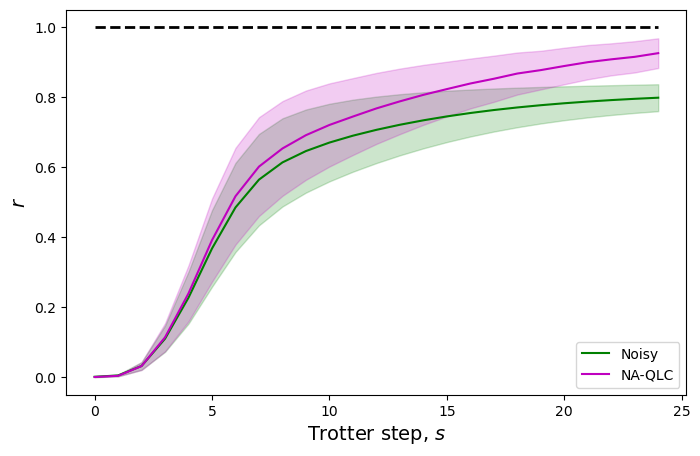

In [11]:
array_r_noisy = np.column_stack(r_now_open_arr)
array_r_naqlc = np.column_stack(r_kasf1_arr)
Norm_factor = 1/np.sqrt(N)

mean_values_r_noisy = np.mean(array_r_noisy, axis=1)
std_values_r_noisy = np.std(array_r_noisy, axis=1)

mean_values_r_naqlc = np.mean(array_r_naqlc, axis=1)
std_values_r_naqlc = np.std(array_r_naqlc, axis=1)


# X-axis indices
x = np.arange(len(mean_values_r_noisy))

# Plot mean with standard deviation
plt.figure(figsize=(8, 5))
plt.plot(x, mean_values_r_noisy, label="Noisy", color="g")
plt.fill_between(x, mean_values_r_noisy - std_values_r_noisy*Norm_factor, mean_values_r_noisy + std_values_r_noisy*Norm_factor, color='g', alpha=0.2)

plt.plot(x, mean_values_r_naqlc, label="NA-QLC", color="m")
plt.fill_between(x, mean_values_r_naqlc - std_values_r_naqlc * Norm_factor, mean_values_r_naqlc + std_values_r_naqlc * Norm_factor, color='m', alpha=0.2)

plt.plot([1]*25,linestyle='--', linewidth=2, color = 'black')


# Labels and legend
plt.xlabel(r"Trotter step, $s$", fontsize=14)
plt.ylabel(r"$r$", fontsize=14)
# plt.title("Mean with Standard Deviation (Column-wise)")
plt.legend()
plt.show()

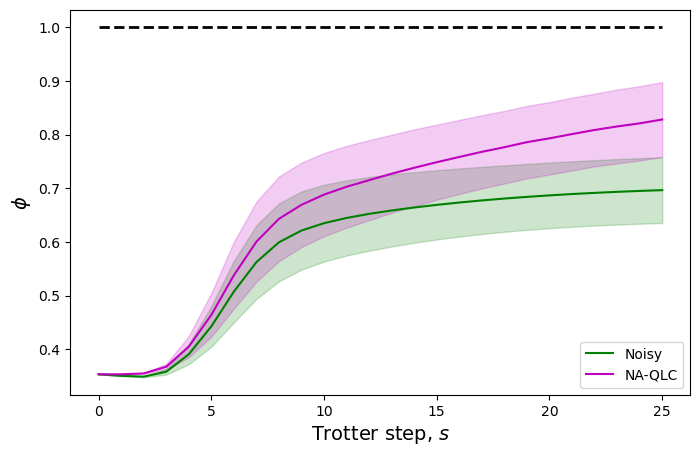

In [12]:
array_phi_noisy = np.column_stack(succ_prob_now_open_arr) 
array_phi_naqlc = np.column_stack(succ_prob_kasf1_arr)
Norm_factor = 1/np.sqrt(N)

mean_values_phi_noisy = np.mean(array_phi_noisy, axis=1)
std_values_phi_noisy = np.std(array_phi_noisy, axis=1)

mean_values_phi_naqlc = np.mean(array_phi_naqlc, axis=1)
std_values_phi_naqlc = np.std(array_phi_naqlc, axis=1)


# X-axis indices
x = np.arange(len(mean_values_phi_noisy))

# Plot mean with standard deviation
plt.figure(figsize=(8, 5))
plt.plot(x, mean_values_phi_noisy, label="Noisy", color="g")
plt.fill_between(x, mean_values_phi_noisy - std_values_phi_noisy * Norm_factor, mean_values_phi_noisy + std_values_phi_noisy * Norm_factor, color='g', alpha=0.2)

plt.plot(x, mean_values_phi_naqlc, label="NA-QLC", color="m")
plt.fill_between(x, mean_values_phi_naqlc - std_values_phi_naqlc * Norm_factor, mean_values_phi_naqlc + std_values_phi_naqlc * Norm_factor, color='m', alpha=0.2)

plt.plot([1]*26,linestyle='--', linewidth=2, color = 'black')

# Labels and legend
plt.xlabel(r"Trotter step, $s$", fontsize=14)
plt.ylabel(r"$\phi$",fontsize=14)
# plt.title("Mean with Standard Deviation (Column-wise)")
plt.legend()
plt.show()

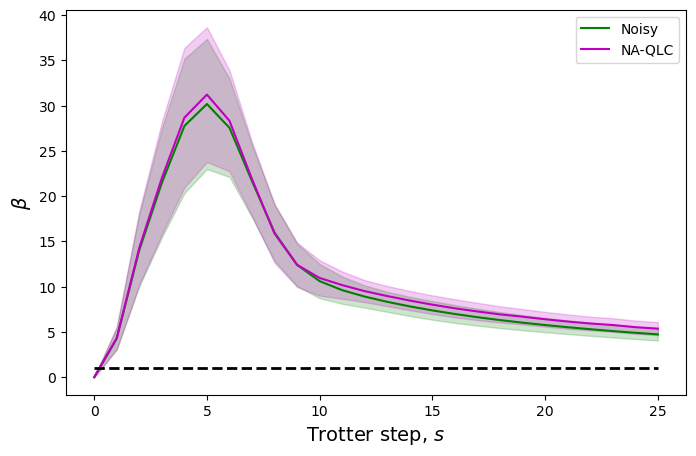

In [13]:
array_beta_noisy = np.column_stack(beta_now_open_arr) 
array_beta_naqlc = np.column_stack(beta_kasf1_arr)
Norm_factor = 1/np.sqrt(N)

mean_values_beta_noisy = np.mean(array_beta_noisy, axis=1)
std_values_beta_noisy = np.std(array_beta_noisy, axis=1)

mean_values_beta_naqlc = np.mean(array_beta_naqlc, axis=1)
std_values_beta_naqlc = np.std(array_beta_naqlc, axis=1)


# X-axis indices
x = np.arange(len(mean_values_beta_noisy))

# Plot mean with standard deviation
plt.figure(figsize=(8, 5))
plt.plot(x, mean_values_beta_noisy, label="Noisy", color="g")
plt.fill_between(x, mean_values_beta_noisy - std_values_beta_noisy * Norm_factor, mean_values_beta_noisy + std_values_beta_noisy * Norm_factor, color='g', alpha=0.2)

plt.plot(x, mean_values_beta_naqlc, label="NA-QLC", color="m")
plt.fill_between(x, mean_values_beta_naqlc - std_values_beta_naqlc * Norm_factor, mean_values_beta_naqlc + std_values_beta_naqlc * Norm_factor, color='m', alpha=0.2)

plt.plot([1]*26,linestyle='--', linewidth=2, color = 'black')

# Labels and legend
plt.xlabel(r"Trotter step, $s$", fontsize=14)
plt.ylabel(r"$\beta$",fontsize=14)
# plt.title("Mean with Standard Deviation (Column-wise)")
plt.legend()
plt.show()

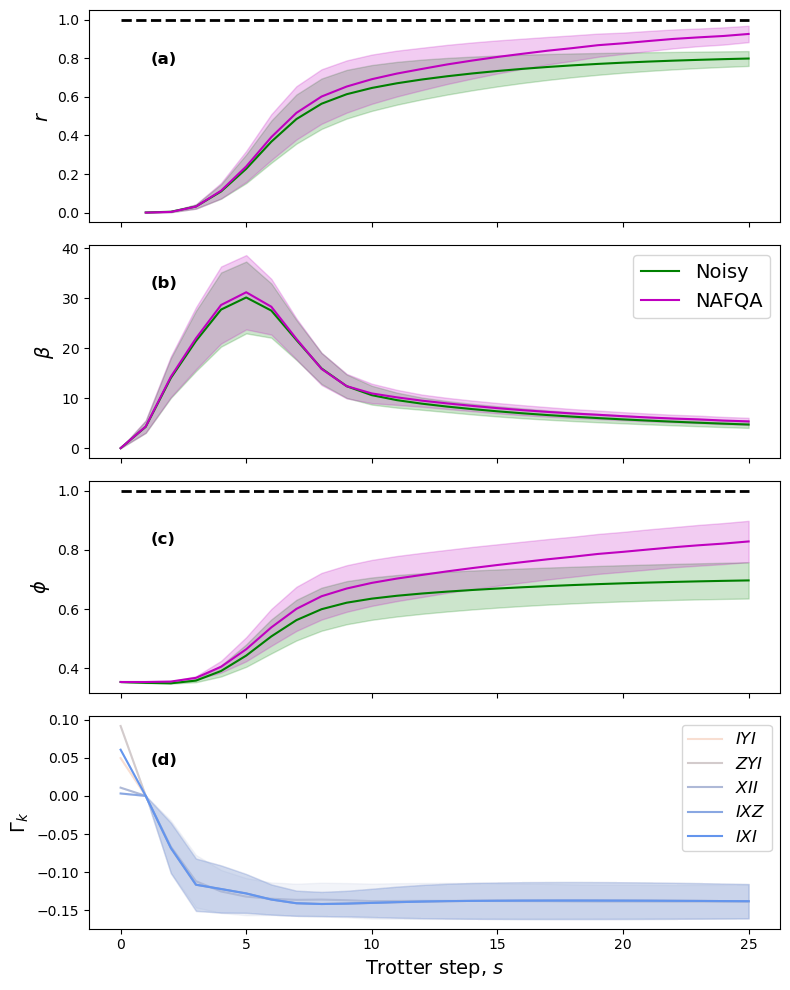

In [16]:
fig, axes = plt.subplots(4, 1, figsize=(8, 10), sharex=True)

x = np.arange(1, len(mean_values_r_noisy)+1)
axes[0].plot(x, mean_values_r_noisy, label="Noisy", color="g")
axes[0].fill_between(x, mean_values_r_noisy - std_values_r_noisy*Norm_factor, mean_values_r_noisy + std_values_r_noisy*Norm_factor, color='g', alpha=0.2)
axes[0].plot(x, mean_values_r_naqlc, label="NA-QLC", color="m")
axes[0].fill_between(x, mean_values_r_naqlc - std_values_r_naqlc * Norm_factor, mean_values_r_naqlc + std_values_r_naqlc * Norm_factor, color='m', alpha=0.2)
axes[0].plot([1]*26,linestyle='--', linewidth=2, color = 'black')
axes[0].set_ylabel(r"$r$", fontsize=14)
axes[0].text(1.2, 0.77, "(a)", fontsize=12, fontweight='bold')


x = np.arange(len(mean_values_beta_noisy))
axes[1].plot(x, mean_values_beta_noisy, label="Noisy", color="g")
axes[1].fill_between(x, mean_values_beta_noisy - std_values_beta_noisy * Norm_factor, mean_values_beta_noisy + std_values_beta_noisy * Norm_factor, color='g', alpha=0.2)
axes[1].plot(x, mean_values_beta_naqlc, label="NAFQA", color="m")
axes[1].fill_between(x, mean_values_beta_naqlc - std_values_beta_naqlc * Norm_factor, mean_values_beta_naqlc + std_values_beta_naqlc * Norm_factor, color='m', alpha=0.2)
# axes[1].plot([1]*26,linestyle='--', linewidth=2, color = 'black')
axes[1].set_ylabel(r"$\beta$",fontsize=14)
# axes[1].set_xlabel(r"Trotter step, $s$", fontsize=12)
axes[1].text(1.2, 32.15, "(b)", fontsize=12, fontweight='bold')
axes[1].legend(fontsize=14)


x = np.arange(len(mean_values_phi_noisy))
axes[2].plot(x, mean_values_phi_noisy, label="Noisy", color="g")
axes[2].fill_between(x, mean_values_phi_noisy - std_values_phi_noisy * Norm_factor, mean_values_phi_noisy + std_values_phi_noisy * Norm_factor, color='g', alpha=0.2)
axes[2].plot(x, mean_values_phi_naqlc, label="NA-FQA", color="m")
axes[2].fill_between(x, mean_values_phi_naqlc - std_values_phi_naqlc * Norm_factor, mean_values_phi_naqlc + std_values_phi_naqlc * Norm_factor, color='m', alpha=0.2)
axes[2].plot([1]*26,linestyle='--', linewidth=2, color = 'black')
axes[2].set_ylabel(r"$\phi$",fontsize=14)
# axes[2].set_xlabel(r"Trotter step, $s$", fontsize=14)
axes[2].text(1.2, 0.82, "(c)", fontsize=12, fontweight='bold')


x = np.arange(len(mean_values_g0))

colors = ['#6495ED', '#89A7E2', '#AEB9D7', '#D3CBCC', '#F8DED1', '#F6BDC0']

# Plot mean with standard deviation
axes[3].plot(x, mean_values_g0, label=r"$IYI$", color=colors[4])
axes[3].fill_between(x, mean_values_g0 - std_values_g0*Norm_factor, mean_values_g0 + std_values_g0 * Norm_factor, color=colors[4], alpha=0.15)

axes[3].plot(x, mean_values_g1, label=r"$ZYI$", color=colors[3])
axes[3].fill_between(x, mean_values_g1 - std_values_g1 * Norm_factor, mean_values_g1 + std_values_g1 * Norm_factor, color=colors[3], alpha=0.15)

axes[3].plot(x, mean_values_g2, label=r"$XII$", color=colors[2])
axes[3].fill_between(x, mean_values_g2 - std_values_g2 * Norm_factor, mean_values_g2 + std_values_g2 * Norm_factor,color=colors[2], alpha=0.15)

axes[3].plot(x, mean_values_g3, label=r"$IXZ$", color=colors[1])
axes[3].fill_between(x, mean_values_g3 - std_values_g3 * Norm_factor, mean_values_g3 + std_values_g3 * Norm_factor,color=colors[1], alpha=0.15)

axes[3].plot(x, mean_values_g4, label=r"$IXI$", color=colors[0])
axes[3].fill_between(x, mean_values_g4 - std_values_g4 * Norm_factor, mean_values_g4 + std_values_g4 * Norm_factor, color=colors[0], alpha=0.15)
axes[3].legend(fontsize=12)
axes[3].set_ylabel(r"$\Gamma_k$",fontsize=14)
axes[3].set_xlabel(r"Trotter step, $s$", fontsize=14)
axes[3].text(1.2, 0.04, "(d)", fontsize=12, fontweight='bold')

# Adjust layout
plt.tight_layout()
filename = f"TFIM_2.pdf"  # Creates "plot_experiment1.png"
plt.savefig(filename)
plt.show()


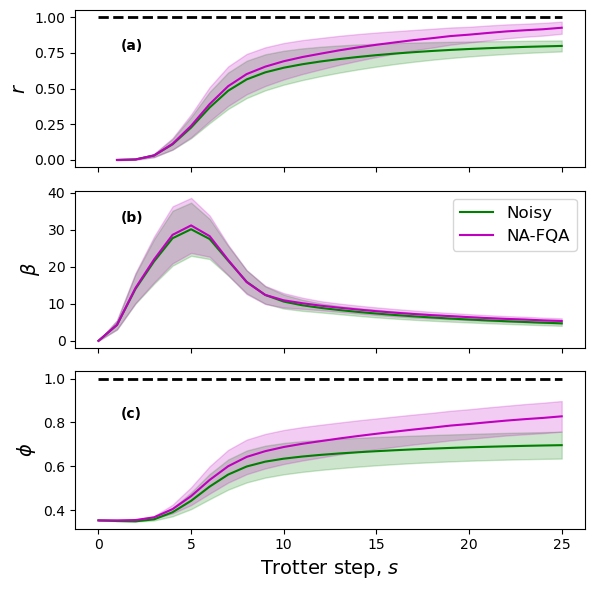

In [75]:
fig, axes = plt.subplots(3, 1, figsize=(6, 6), sharex=True)

x = np.arange(1, len(mean_values_r_noisy)+1)
axes[0].plot(x, mean_values_r_noisy, label="Noisy", color="g")
axes[0].fill_between(x, mean_values_r_noisy - std_values_r_noisy*Norm_factor, mean_values_r_noisy + std_values_r_noisy*Norm_factor, color='g', alpha=0.2)
axes[0].plot(x, mean_values_r_naqlc, label="NA-QLC", color="m")
axes[0].fill_between(x, mean_values_r_naqlc - std_values_r_naqlc * Norm_factor, mean_values_r_naqlc + std_values_r_naqlc * Norm_factor, color='m', alpha=0.2)
axes[0].plot([1]*26,linestyle='--', linewidth=2, color = 'black')
axes[0].set_ylabel(r"$r$", fontsize=14)
axes[0].text(1.2, 0.77, "(a)", fontsize=10, fontweight='bold')


x = np.arange(len(mean_values_beta_noisy))
axes[1].plot(x, mean_values_beta_noisy, label="Noisy", color="g")
axes[1].fill_between(x, mean_values_beta_noisy - std_values_beta_noisy * Norm_factor, mean_values_beta_noisy + std_values_beta_noisy * Norm_factor, color='g', alpha=0.2)
axes[1].plot(x, mean_values_beta_naqlc, label="NA-FQA", color="m")
axes[1].fill_between(x, mean_values_beta_naqlc - std_values_beta_naqlc * Norm_factor, mean_values_beta_naqlc + std_values_beta_naqlc * Norm_factor, color='m', alpha=0.2)
# axes[1].plot([1]*26,linestyle='--', linewidth=2, color = 'black')
axes[1].set_ylabel(r"$\beta$",fontsize=14)
# axes[1].set_xlabel(r"Trotter step, $s$", fontsize=12)
axes[1].text(1.2, 32.15, "(b)", fontsize=10, fontweight='bold')
axes[1].legend(fontsize=12)



x = np.arange(len(mean_values_phi_noisy))
axes[2].plot(x, mean_values_phi_noisy, label="Noisy", color="g")
axes[2].fill_between(x, mean_values_phi_noisy - std_values_phi_noisy * Norm_factor, mean_values_phi_noisy + std_values_phi_noisy * Norm_factor, color='g', alpha=0.2)
axes[2].plot(x, mean_values_phi_naqlc, label="NA-FQA", color="m")
axes[2].fill_between(x, mean_values_phi_naqlc - std_values_phi_naqlc * Norm_factor, mean_values_phi_naqlc + std_values_phi_naqlc * Norm_factor, color='m', alpha=0.2)
axes[2].plot([1]*26,linestyle='--', linewidth=2, color = 'black')
axes[2].set_ylabel(r"$\phi$",fontsize=14)
axes[2].set_xlabel(r"Trotter step, $s$", fontsize=14)
axes[2].text(1.2, 0.82, "(c)", fontsize=10, fontweight='bold')


# Adjust layout
plt.tight_layout()
filename = f"TFIM.pdf"  # Creates "plot_experiment1.png"
plt.savefig(filename)
plt.show()
